<a href="https://colab.research.google.com/github/mdominguezd/PyTorch_Training/blob/main/u_net_implementation_based_dl_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using U-Net model to predict cashew crop extent remote sensing images

## 1) Import data and create dataset

In [1]:
!wget -O Tanzania.zip https://www.dropbox.com/scl/fi/e1b56rmeulqezgw9u10j3/PlanetTanzania.zip?rlkey=fqbtpntv7qiz66g5vx0d9ccum&dl=0
!wget -O IvoryCoast.zip https://www.dropbox.com/scl/fi/a7u7m0n6xllmr9vob8g3z/PlanetIvoryCoast.zip?rlkey=uw81nyqdwjgzrhrirs6j96pfc&dl=0

--2023-10-01 18:48:26--  https://www.dropbox.com/scl/fi/e1b56rmeulqezgw9u10j3/PlanetTanzania.zip?rlkey=fqbtpntv7qiz66g5vx0d9ccum
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/e1b56rmeulqezgw9u10j3/PlanetTanzania.zip?rlkey=fqbtpntv7qiz66g5vx0d9ccum [following]
--2023-10-01 18:48:26--  https://www.dropbox.com/e/scl/fi/e1b56rmeulqezgw9u10j3/PlanetTanzania.zip?rlkey=fqbtpntv7qiz66g5vx0d9ccum
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4db0fa03514b614b090660f967.dl.dropboxusercontent.com/cd/0/inline/CEzbgURfx1spSL6BFZy8ttE8G2bVoF2G83uriYf54fnPbCg7wKUyhQW35aOqOYxBC0xwgRCRQlNy14JD_Zh7UxxBBDGyNfUniGDlAAH-E9qlEKO1Egh_xBKvi7M7DNwDU3Rzvj8fbogWZRwiFTuekJ6K/file# [following]
--2023-10-01 18:48:27--  https://uc4

Import necessary libraries

In [83]:
import os
import numpy as np
import geopandas as gpd
import pandas as pd
from zipfile import ZipFile
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as T
from torch.utils.data import random_split
from skimage import io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import shutil
# import torchvision

In [84]:
with ZipFile("Tanzania.zip", 'r') as zipped:
    zipped.extractall(path="./")
with ZipFile("IvoryCoast.zip", 'r') as zipped:
    zipped.extractall(path="./")

FileNotFoundError: ignored

In [85]:
os.remove('Tanzania.zip')
os.remove('IvoryCoast.zip')

FileNotFoundError: ignored

In [86]:
transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomResizedCrop((256,256), scale = (0.8,1)),
    T.RandomEqualize(0.5)
    ])

In [87]:
class Tanzania_Dataset(Dataset):
  def __init__(self, img_folder, transform = None):
    self.img_folder = img_folder
    self.transform = transform

  def __len__(self):
    return int(len(os.listdir(self.img_folder))/2)

  def plot_imgs(self, idx):
    fig, ax = plt.subplots(1,2,figsize = (12,6))

    im, g = self.__getitem__(idx)

    ax[0].imshow(im[[2,1,0],:,:].permute(1,2,0))
    ax[0].set_title('Planet image')
    ax[1].imshow(g[0,:,:])
    ax[1].set_title('Cashew crops GT')

  def __getitem__(self, idx):
    #__getitem__ asks for the sample number idx.

    conversion = T.ToTensor()
    img = io.imread(fname = self.img_folder + '/CroppedTanzaniaStudyArea_{:05d}'.format(idx) + '.tif').astype(np.float32)

    # img = img/np.max(np.max(img, 0), 0)

    img = img/1500

    img[img > 1] = 1

    img = conversion(img).float()

    img = torchvision.datapoints.Image(img)

    GT = io.imread(fname = self.img_folder + '/CroppedTanzaniaGT_{:05d}'.format(idx) + '.tif').astype(np.float32)

    GT = torch.flip(conversion(GT), dims = (1,))

    GT = torchvision.datapoints.Image(GT)

    if self.transform != None:
        GT, img = self.transform(GT, img)

    return img, GT

In [88]:
class Ivy_Dataset(Dataset):
  def __init__(self, img_folder, transform = None): #GT_folder
    self.img_folder = img_folder
    self.transform = transform

  def __len__(self):
    return int(len(os.listdir(self.img_folder))/2)

  def plot_imgs(self, idx):
    fig, ax = plt.subplots(1,2,figsize = (12,6))

    im, g = self.__getitem__(idx)

    ax[0].imshow(im[[2,1,0],:,:].permute(1,2,0))
    ax[0].set_title('Planet image')
    ax[1].imshow(g[0,:,:])
    ax[1].set_title('Cashew crops GT')

  def __getitem__(self, idx):
    #__getitem__ asks for the sample number idx.
    conversion = T.ToTensor()
    img = io.imread(fname = self.img_folder + '/CroppedIvoryCoastStudyArea_{:05d}'.format(idx) + '.tif').astype(np.float32)

    # img = img/np.max(img)
    img = img/1500

    img[img > 1] = 1

    img = conversion(img).float()

    img = torchvision.datapoints.Image(img)

    GT = io.imread(fname = self.img_folder + '/CroppedIvoryCoastGT_{:05d}'.format(idx) + '.tif').astype(np.float32)

    GT = torch.flip(conversion(GT), dims = (1,))

    GT = torchvision.datapoints.Image(GT)

    if self.transform != None:
        GT, img = self.transform(GT, img)

    return img, GT

In [89]:
DS = Ivy_Dataset('IvoryCoast', transform)
# DS = Tanzania_Dataset('Tanzania', transform)

DS.__len__()

1629

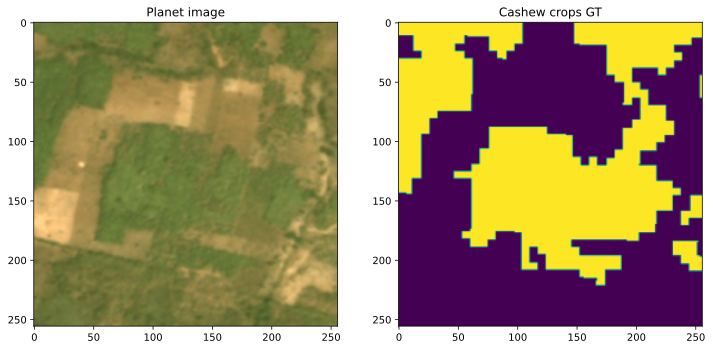

In [90]:
DS.plot_imgs(1040)

In [91]:
#Set params
batch_size = 8
epochs = 15

In [92]:
generator1 = torch.Generator().manual_seed(42)

train_DS, val_DS, test_DS = random_split(DS, [0.8, 0.15, 0.05], generator=generator1)

#Note that we shuffle the data for the training set, but not for the validation set:
train_loader = torch.utils.data.DataLoader(dataset=train_DS, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_DS, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_DS, batch_size=batch_size, shuffle=False)

In [93]:
iterable_train_loader = enumerate(train_loader)

## 2) Build and train the model

### 2.1) Building blocks of a UNet

Take from: https://github.com/milesial/Pytorch-UNet/tree/master

In [94]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # print(diffY, diffX)

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

### 2.2 Build the network class

Taken from: https://github.com/milesial/Pytorch-UNet/tree/master

In [95]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

        self.apply(self._init_weights)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def return_FE(self, x, up_layer = 0):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        if up_layer == 0:
            return x5
        if up_layer >= 1:
            x = self.up1(x5, x4)
            return x
        if up_layer >= 2:
            x = self.up2(x, x3)
            return x
        if up_layer >= 3:
            x = self.up3(x, x2)
            return x
        if up_layer >= 4:
            x = self.up4(x, x1)
            return x


    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            # module.weight.data.normal_(mean=0.0, std=1.0)
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    # def use_checkpointing(self):
    #     self.inc = torch.utils.checkpoint(self.inc)
    #     self.down1 = torch.utils.checkpoint(self.down1)
    #     self.down2 = torch.utils.checkpoint(self.down2)
    #     self.down3 = torch.utils.checkpoint(self.down3)
    #     self.down4 = torch.utils.checkpoint(self.down4)
    #     self.up1 = torch.utils.checkpoint(self.up1)
    #     self.up2 = torch.utils.checkpoint(self.up2)
    #     self.up3 = torch.utils.checkpoint(self.up3)
    #     self.up4 = torch.utils.checkpoint(self.up4)
    #     self.outc = torch.utils.checkpoint(self.outc)

We can now check that it works by feeding a simple input (an empty image) to our network. Note that in pytorch, 2D inputs are defined as $(N, C, H, W)$ where $N$ is the number of samples (in our case 1), $C$ is the number of channels (in our case 4) and $H$ and $W$ are the height and width of the sample respectively.

In [96]:
# network = UNet(4,2)
# batch = next(iterable_train_loader)
# output = network(batch[1][0])
# print(output.shape)

We obtained an output of the same spatial input size, but with 6 channels (one for each class), which is what we wanted!

Remember to comment out or remove any print statements on the forward method in order to prevent a flood of prints when training the model.

### 3.4) Training the model

Now that we have a model and our training data, we are going to be able to actually train the model.

The most common way to train such a model is to proceed by *epochs*: during one epoch, we go through the training set once (feedforwarding the batches and backpropagate the gradients). Then we will compute the loss on the validation set to check that we are not overfitting or underfitting.

So the first thing we want to do is to define the loss function. Once again, pytorch implements several of them. The one that we will use is a classification loss (after all, we are trying to assign a class to each of the pixels) and is called the cross-entropy. It is defined as follow:

$l(\mathbf{y_i}, \hat{y}_i) = -  \log \left(\frac{exp(y_{i,\hat{y}_i})}{\sum_c exp(y_{i,c})}\right)$, where $y_{i,c}$ is the score of class $c$ at pixel $i$. To use it in pytorch, we just instantiate the following:

In [97]:
loss_function = torch.nn.CrossEntropyLoss()

We now have all the ingredients required to do the training!

So let's build our training loop and run it!

**Careful:**
* you should enable GPU in your collab at this point. To do so go to runtime -> Change runtime type -> Hardware accelerator and select "GPU";
* the default epoch number (3) should run in around 5min (on GPU).

In [98]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [99]:
# iter = enumerate(val_loader)
# i, (inputs, GTs) = next(iter)
# GTs.shape
# pred = network(inputs.to(device))
# pred.shape

KeyboardInterrupt: ignored

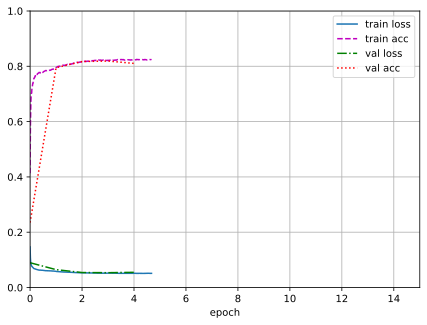

In [100]:
!pip install d2l==0.14.2 -q
from d2l import torch as d2l
from collections import deque
from statistics import mean


def evaluate(net, validate_loader, loss_function):
  #You need to set the network to eval mode when using batch normalization (to
  #be consistent across evaluation samples, we use mean and stddev computed
  #during training when doing inference, as opposed to ones computed on the
  #batch) or dropout (you want to use all the parameters during inference).
  net.eval()  # Set the model to evaluation mode
  device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(4)
  #This line reduces the memory by not tracking the gradients. Also to be used
  #during inference.
  with torch.no_grad():
    for i, (inputs, GTs) in enumerate(validate_loader):
      #Send inputs and GTs them to the computation device (i.e. GPU). The GTs tensor
      #has to be converted to nn.LongTensor type (a type of integer) and turned into
      #a 3D tensor by removing dimension 1 with the squeeze() function.
      inputs = inputs.to(device)
      GTs = GTs.type(torch.long).squeeze().to(device)
      pred = network(inputs)
      # pred = pred[:,0,:,:].float()
      # print(pred[0,0,0], GTs[0,0,0])
      loss = loss_function(pred, GTs)
      overall_accuracy = (pred.max(1)[1]==GTs).float().mean()
      metric.add(loss, GTs.shape[0], overall_accuracy, 1)
  return metric


number_epochs = epochs

animator = d2l.Animator(xlabel='epoch', xlim=[0, number_epochs], ylim=[0, 1],
                        legend=['train loss', 'train acc', 'val loss', 'val acc'],
                        fmts=('-', 'm--', 'g-.', 'r:'),
                        figsize=(7, 5))

network = UNet(n_channels=4, n_classes=2, bilinear=True)
network.to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=0.1)
#Training metrics are computed as a running average of the last x samples
loss_train = deque(maxlen=len(train_loader))
accuracy_train = deque(maxlen=len(train_loader))

for epoch in range(number_epochs):
  #Validation phase:
  metric_val = evaluate(network, val_loader, loss_function)
  animator.add(epoch,(None, None, metric_val[0]/metric_val[1], metric_val[2]/metric_val[3]))

  #Training phase:
  network.train() #indicate to the network that we enter training mode
  for i, (inputs, GTs) in enumerate(train_loader):
    inputs = inputs.to(device)
    GTs = GTs.type(torch.long).squeeze().to(device)
    #We set the gradients of the model to 0.
    optimizer.zero_grad()
    pred = network(inputs)
    loss = loss_function(pred, GTs)
    overall_accuracy = (pred.max(1)[1]==GTs).float().mean()
    #We accumulate the gradients...
    loss.backward()
    #...and we update the parameters according to the gradients.
    optimizer.step()
    loss_train.append(loss.item()/GTs.shape[0])
    accuracy_train.append(overall_accuracy.item())
    animator.add(epoch+i/len(train_loader),
                      (mean(loss_train), mean(accuracy_train), None, None))


  if (epoch//2 == epoch/2):
      #After each training epoch, reduce the learning rate by a factor of 0.2
      optimizer.param_groups[0]['lr'] *= 0.2

metric_val = evaluate(network, val_loader, loss_function)
animator.add(epoch+1,(None, None, metric_val[0]/metric_val[1], metric_val[2]/metric_val[3]))


#Optional, if you want to save your model (you will need to use a folder where you have writing rights):
#torch.save(network.state_dict(), os.path.join(base_folder, 'WeightsVaihingen/', 'Hypercolumns_' + str(number_epochs) + "epochs.pth")
#torch.save(network.state_dict(), os.path.join(base_folder, 'WeightsVaihingen/', 'Hypercolumns_augm_weigths_' + str(number_epochs) + 'epochs.pth'))


In [40]:
torch.save(network, 'U_Net_SourceOnlyCIVwithImAug.pt')

In [50]:
img, gt = DS.__getitem__(1)

F = network.return_FE(img[None, :, :, :].to(device))
F.flatten().shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
 

torch.Size([131072])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


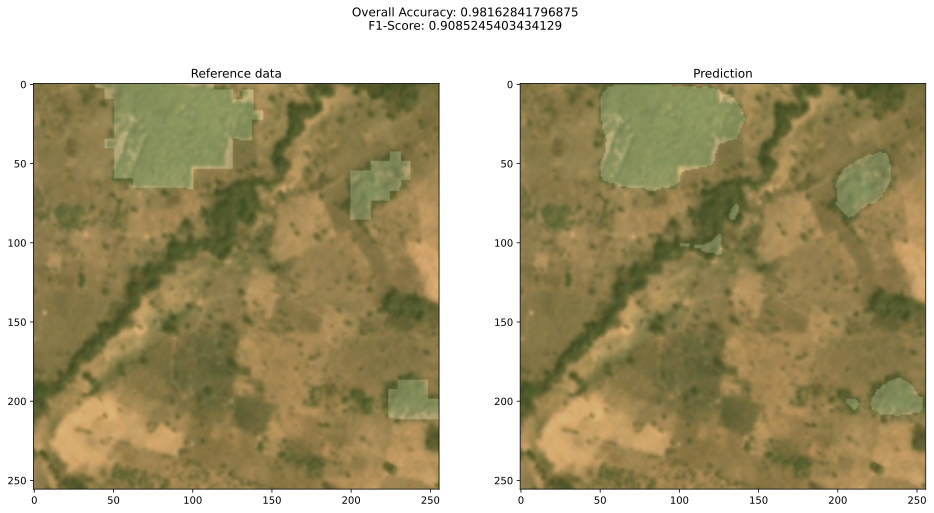

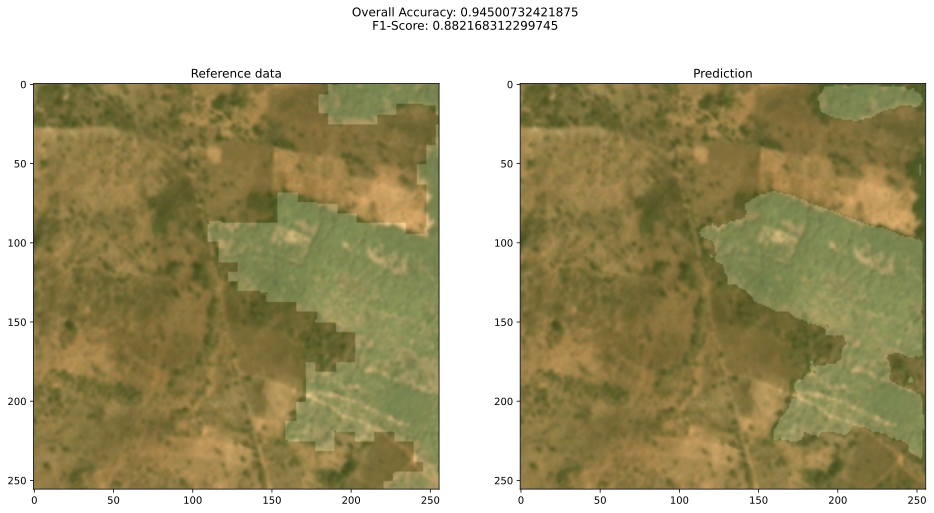

In [44]:
def F1(pred, gt):

    cl = pred - gt.numpy()
    FN = np.sum(cl == -1)
    FP = np.sum(cl == 1)
    TN = np.sum(pred[((pred == 0)&(cl == 0))[0]])
    TP = np.sum(pred[((pred == 1)&(cl == 0))[0]])

    if TP == 0 :
      F1 = 0
    else:
      prec = TP/(TP+FP)
      recall = TP/(TP+FN)

      F1 = 2*(prec*recall)/(prec+recall)

    return F1

t_DS = Tanzania_Dataset('Tanzania')
c_DS = Ivy_Dataset('IvoryCoast')

l = []
oa = []

for i in range(c_DS.__len__()):
  img, gt = c_DS.__getitem__(i)

  pred = network(img[None, :, :, :].to(device))
  pred = pred[0,:,:,:].max(0)[1].cpu().numpy()

  overall_accuracy = np.mean(pred == gt.numpy())
  f1 = F1(pred, gt)

  l.append(f1)
  oa.append(overall_accuracy)

  if f1 > 0.88:
      img = img[[2,1,0], :, :].permute(1,2,0)

      f, ax = plt.subplots(1,2,figsize = (16,8))
      ax[0].imshow(img)
      ax[0].imshow(gt[0], alpha = 0.4, cmap = 'gray')
      ax[0].set_title('Reference data')

      ax[1].imshow(img)
      ax[1].imshow(pred, alpha = 0.4, cmap = 'gray')
      ax[1].set_title('Prediction')

      plt.suptitle('Overall Accuracy: ' + str(overall_accuracy) + '\nF1-Score: '+str(f1))

In [45]:
mean(l)

0.42514695036006295

In [46]:
mean(oa)

0.7540408907820653

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, network.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

17263618


This is batch number 0


Text(0.5, 1.0, 'Prediction')

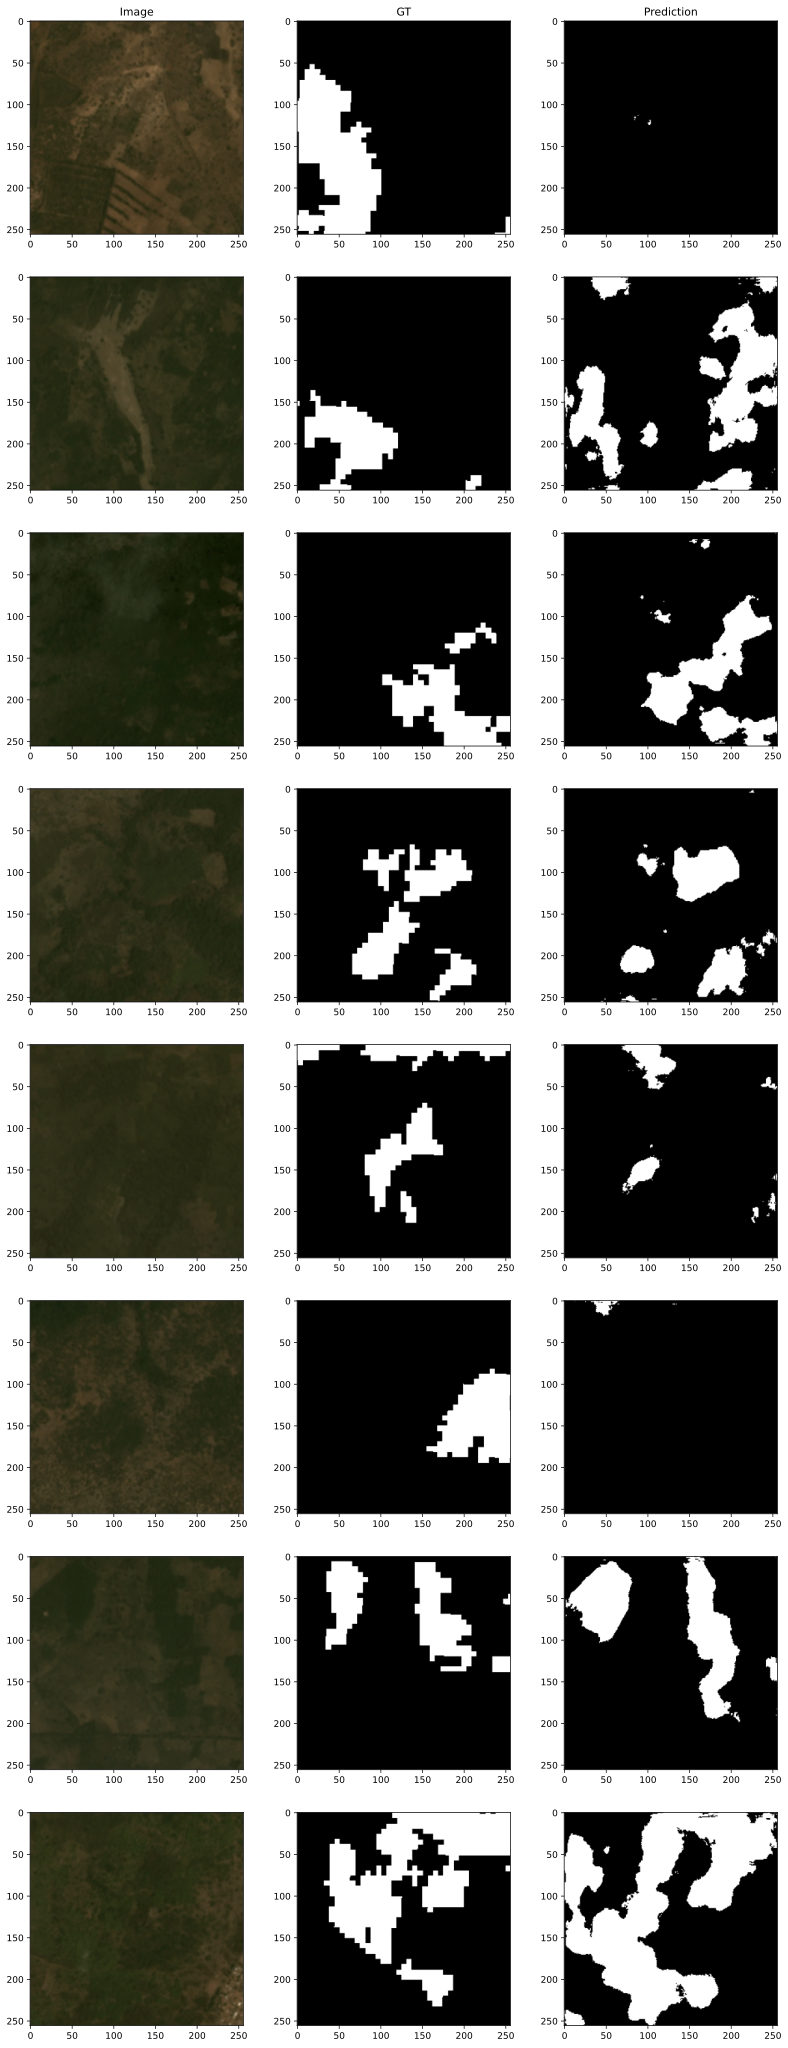

In [ ]:
batch = next(iterable_train_loader)

pred = network(batch[1][0].to(device))

# print(loss_function(pred, batch[1][1].to(device)))
print('This is batch number '+ str(batch[0]))
fig, axs = plt.subplots(batch_size, 3)
fig.set_size_inches(15,5*batch_size)
for i in range(batch_size):
  axs[i,0].imshow(batch[1][0].permute(0,2,3,1)[i,:,:,[2,1,0]], vmin =0, vmax = 1)
  axs[i,1].imshow(batch[1][1][i,0,:,:],cmap=plt.get_cmap('gray'),vmin=0,vmax=1)
  axs[i,2].imshow(pred[i,:,:,:].max(0)[1].cpu(),cmap=plt.get_cmap('gray'))
axs[0,0].set_title('Image')
axs[0,1].set_title('GT')
axs[0,2].set_title('Prediction')

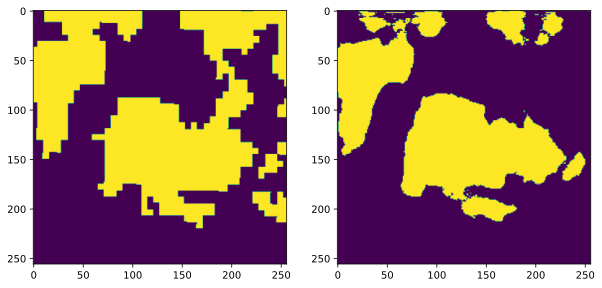

In [ ]:
im, gt = DS.__getitem__(1040)
pred = network(im[None, :, :, :].to(device))
pred_ = pred[0,:,:,:].max(0)[1].cpu().numpy()

figs, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(gt[0])
ax[1].imshow(pred_)